In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.rcParams['figure.dpi'] = 150

import matplotlib.pyplot as plt
matplotlib.rcParams.update({'figure.autolayout': True})

import seaborn as sns
sns.set(style='whitegrid', font_scale=0.9, rc={"lines.linewidth": 1.4,
                                           'lines.markersize': 1.6}, font="serif")

# import jtplot module in notebook
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='oceans16')

# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
jtplot.style(context='paper', fscale=1, spines=False, gridlines='--')

# turn on X- and Y-axis tick marks (default=False)
# turn off the axis grid lines (default=True)
# and set the default figure size

/Users/dylancromer/.venvs/maszcal/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  


In [3]:
import numpy as np
from maszcal.cosmology import CosmoParams
import maszcal.twohalo

In [4]:
two_halo_model = maszcal.twohalo.TwoHaloShearModel(cosmo_params=CosmoParams())

In [7]:
help(two_halo_model.esd)

Help on method esd in module maszcal.twohalo:

esd(rs, mus, zs) method of maszcal.twohalo.TwoHaloShearModel instance



In [5]:
zs = np.linspace(0, 1, 6)
mus = np.linspace(np.log(1e14), np.log(1e15), 6)
rs = np.logspace(-1, np.log10(25), 60)

In [8]:
esds = two_halo_model.esd(rs, mus, zs)

In [13]:
colors = ['#79c45b', '#e0666f', '#65c7a7', '#d28347', '#639cda', '#bfb357']

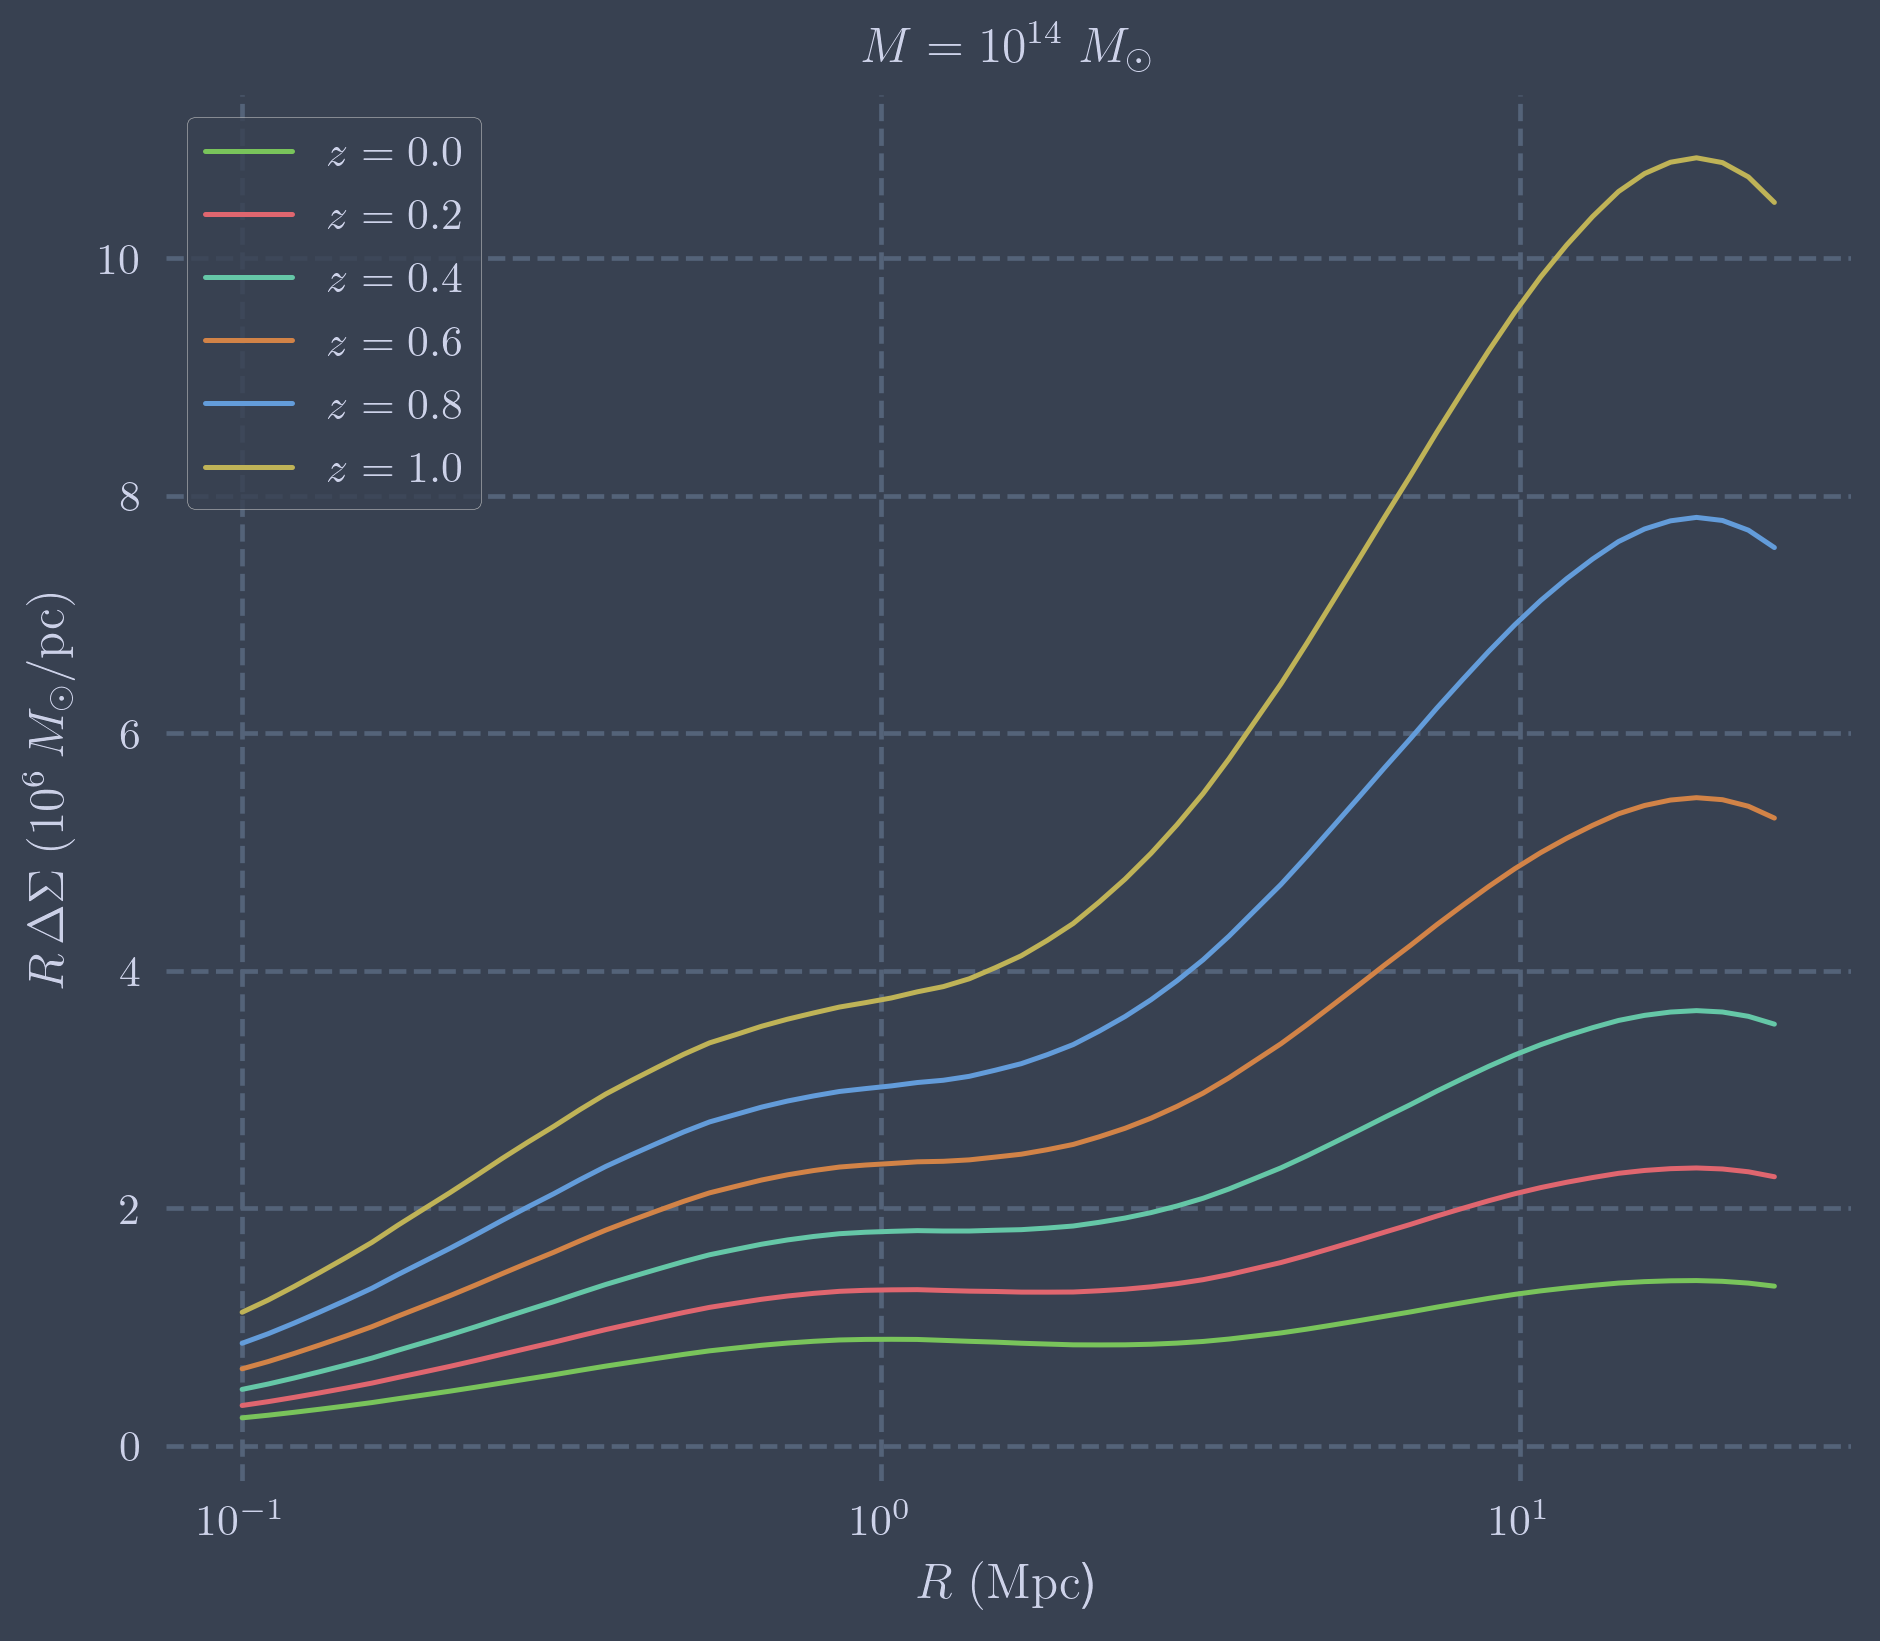

In [24]:
for i in range(6):
    plt.plot(rs, rs*esds[0, i, :], color=colors[i], label=fr'$z={round(zs[i], 2)}$')
plt.xscale('log')
plt.xlabel(r'$R \; (\mathrm{Mpc}$)')
plt.ylabel(r'$R \, \Delta \Sigma \; (10^6 \, M_\odot/\mathrm{pc})$')
plt.legend(loc='best')
plt.title(r'$M = 10^{14} \; M_\odot$')
pass

plt.savefig('2-halo-r-esd_zs.pdf')

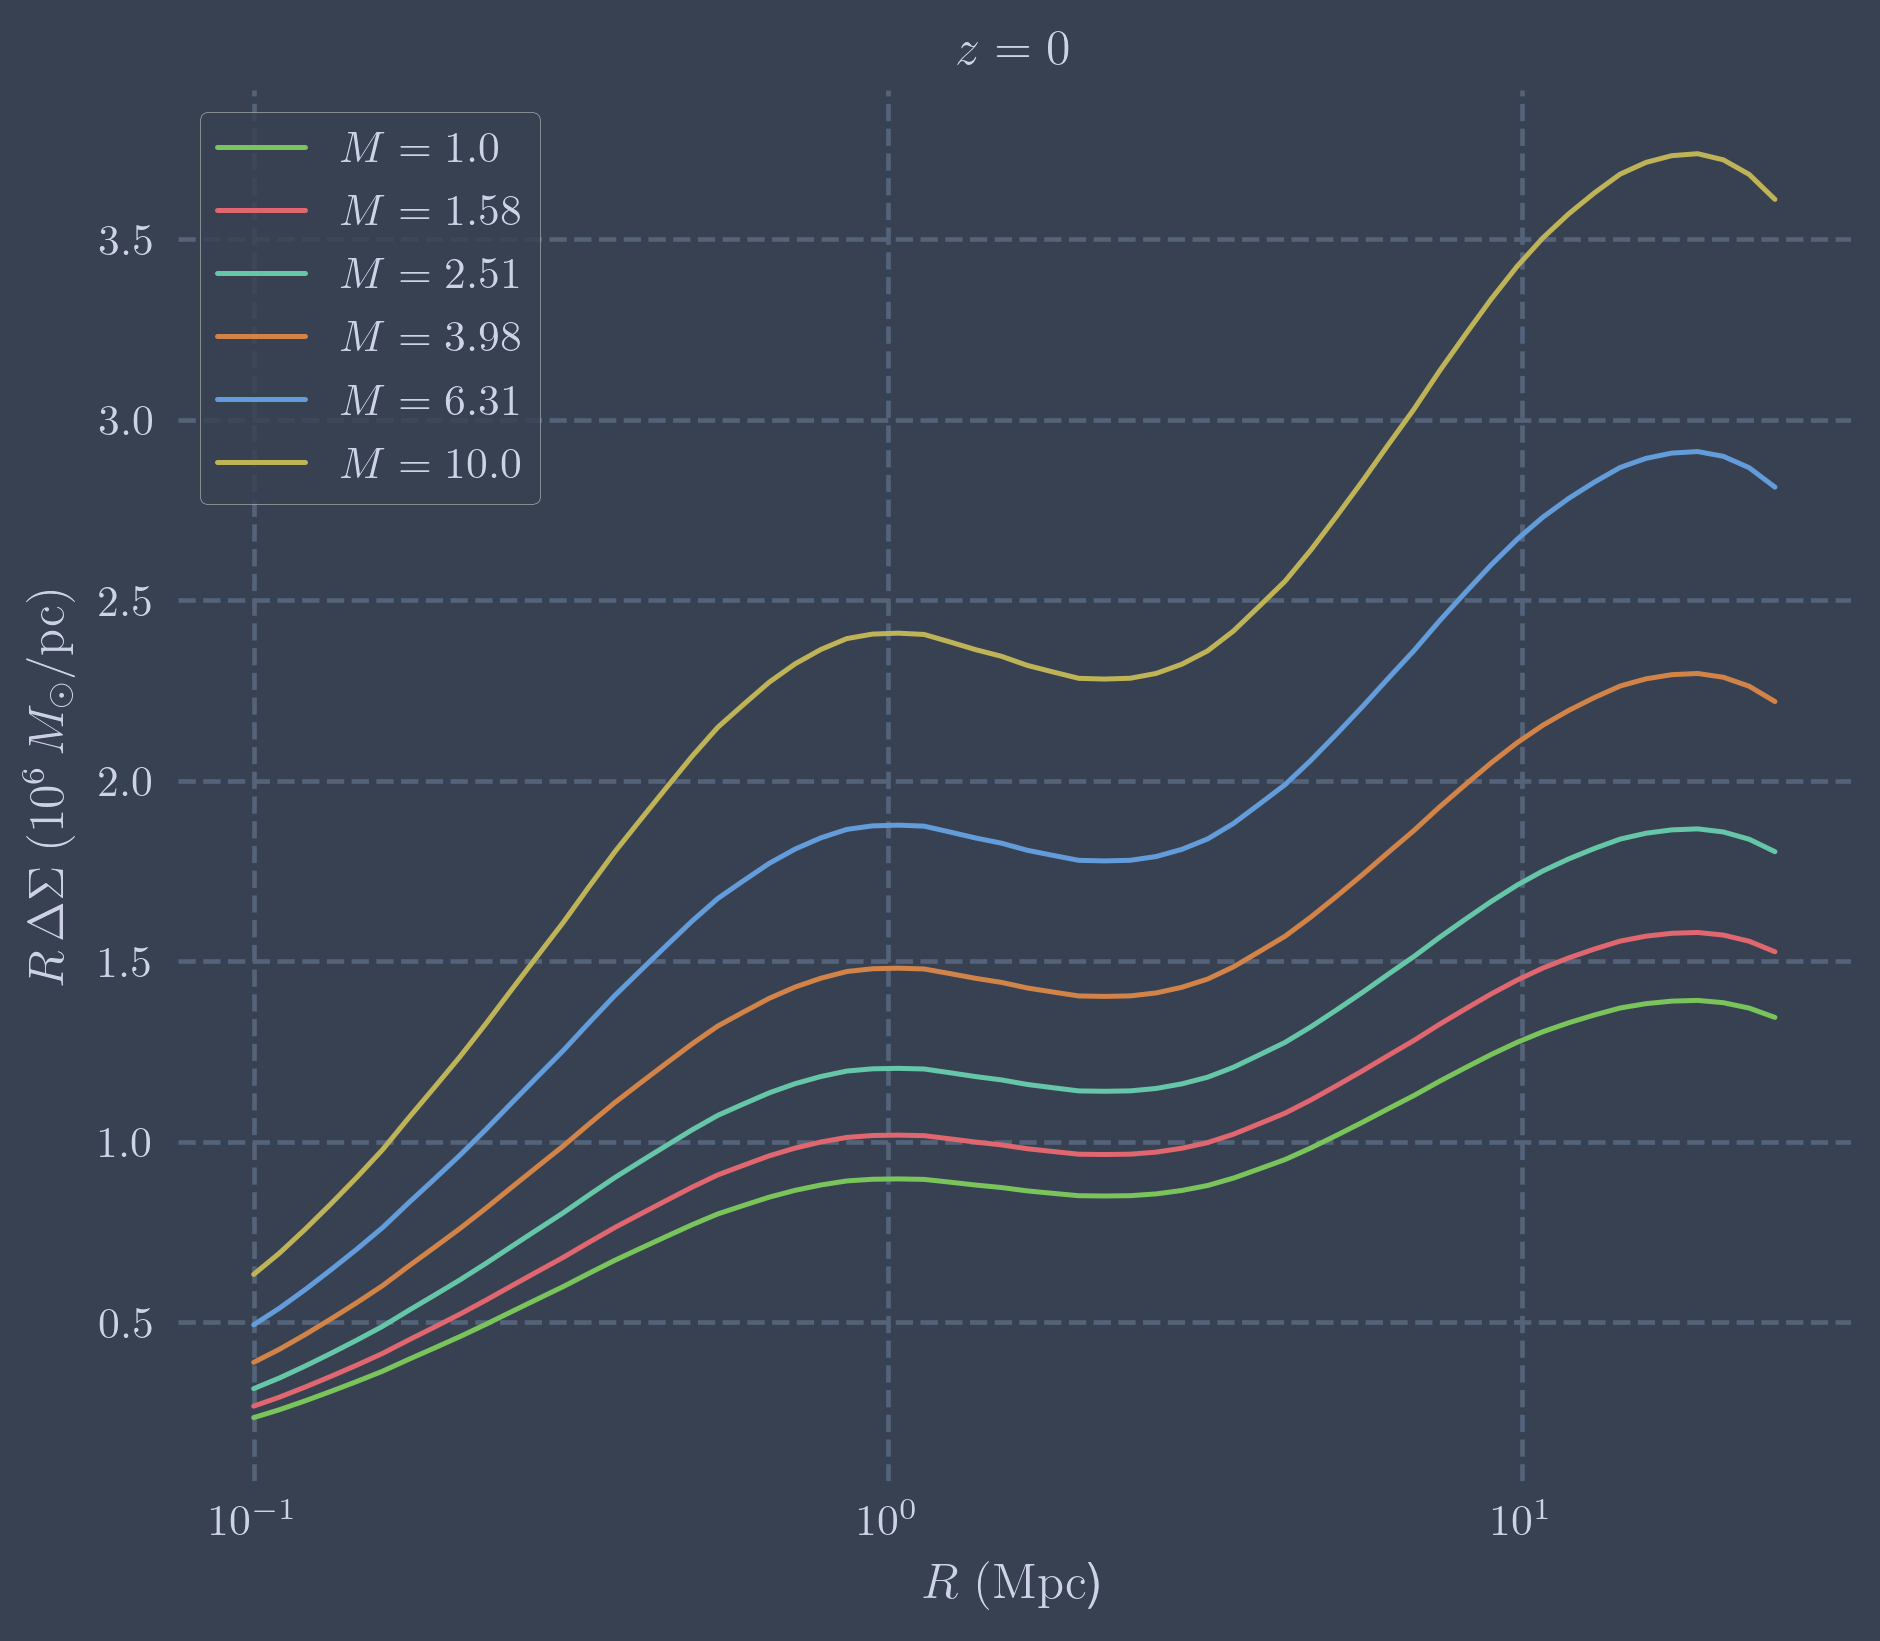

In [25]:
for i in range(6):
    plt.plot(rs, rs*esds[i, 0, :], color=colors[i], label=fr'$M={round(np.exp(mus[i])/1e14, 2)}$')
plt.xscale('log')
plt.xlabel(r'$R \; (\mathrm{Mpc}$)')
plt.ylabel(r'$R \, \Delta \Sigma \; (10^6 \, M_\odot/\mathrm{pc})$')
plt.legend(loc='best')
plt.title(r'$z = 0$')
pass

plt.savefig('2-halo-r-esd_ms.pdf')

In [26]:
help(maszcal.twohalo.TwoHaloShearModel)

Help on class TwoHaloShearModel in module maszcal.twohalo:

class TwoHaloShearModel(builtins.object)
 |  TwoHaloShearModel(cosmo_params: object, delta: int = 200, mass_definition: str = 'mean', comoving: bool = True, matter_power_class: object = <class 'maszcal.matter.Power'>) -> None
 |  
 |  TwoHaloShearModel(cosmo_params: object, delta: int = 200, mass_definition: str = 'mean', comoving: bool = True, matter_power_class: object = <class 'maszcal.matter.Power'>)
 |  
 |  Methods defined here:
 |  
 |  __eq__(self, other)
 |  
 |  __init__(self, cosmo_params: object, delta: int = 200, mass_definition: str = 'mean', comoving: bool = True, matter_power_class: object = <class 'maszcal.matter.Power'>) -> None
 |  
 |  __post_init__(self)
 |  
 |  __repr__(self)
 |  
 |  density_interpolator(self, rs, mus, zs)
 |  
 |  esd(self, rs, mus, zs)
 |  
 |  matter_density(self, zs)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |

In [27]:
two_halo_model_lin = maszcal.twohalo.TwoHaloShearModel(cosmo_params=CosmoParams())
two_halo_model_lin.USE_NONLINEAR_MATTER_POWER = False

In [31]:
esds_lin = two_halo_model_lin.esd(rs, mus, zs)

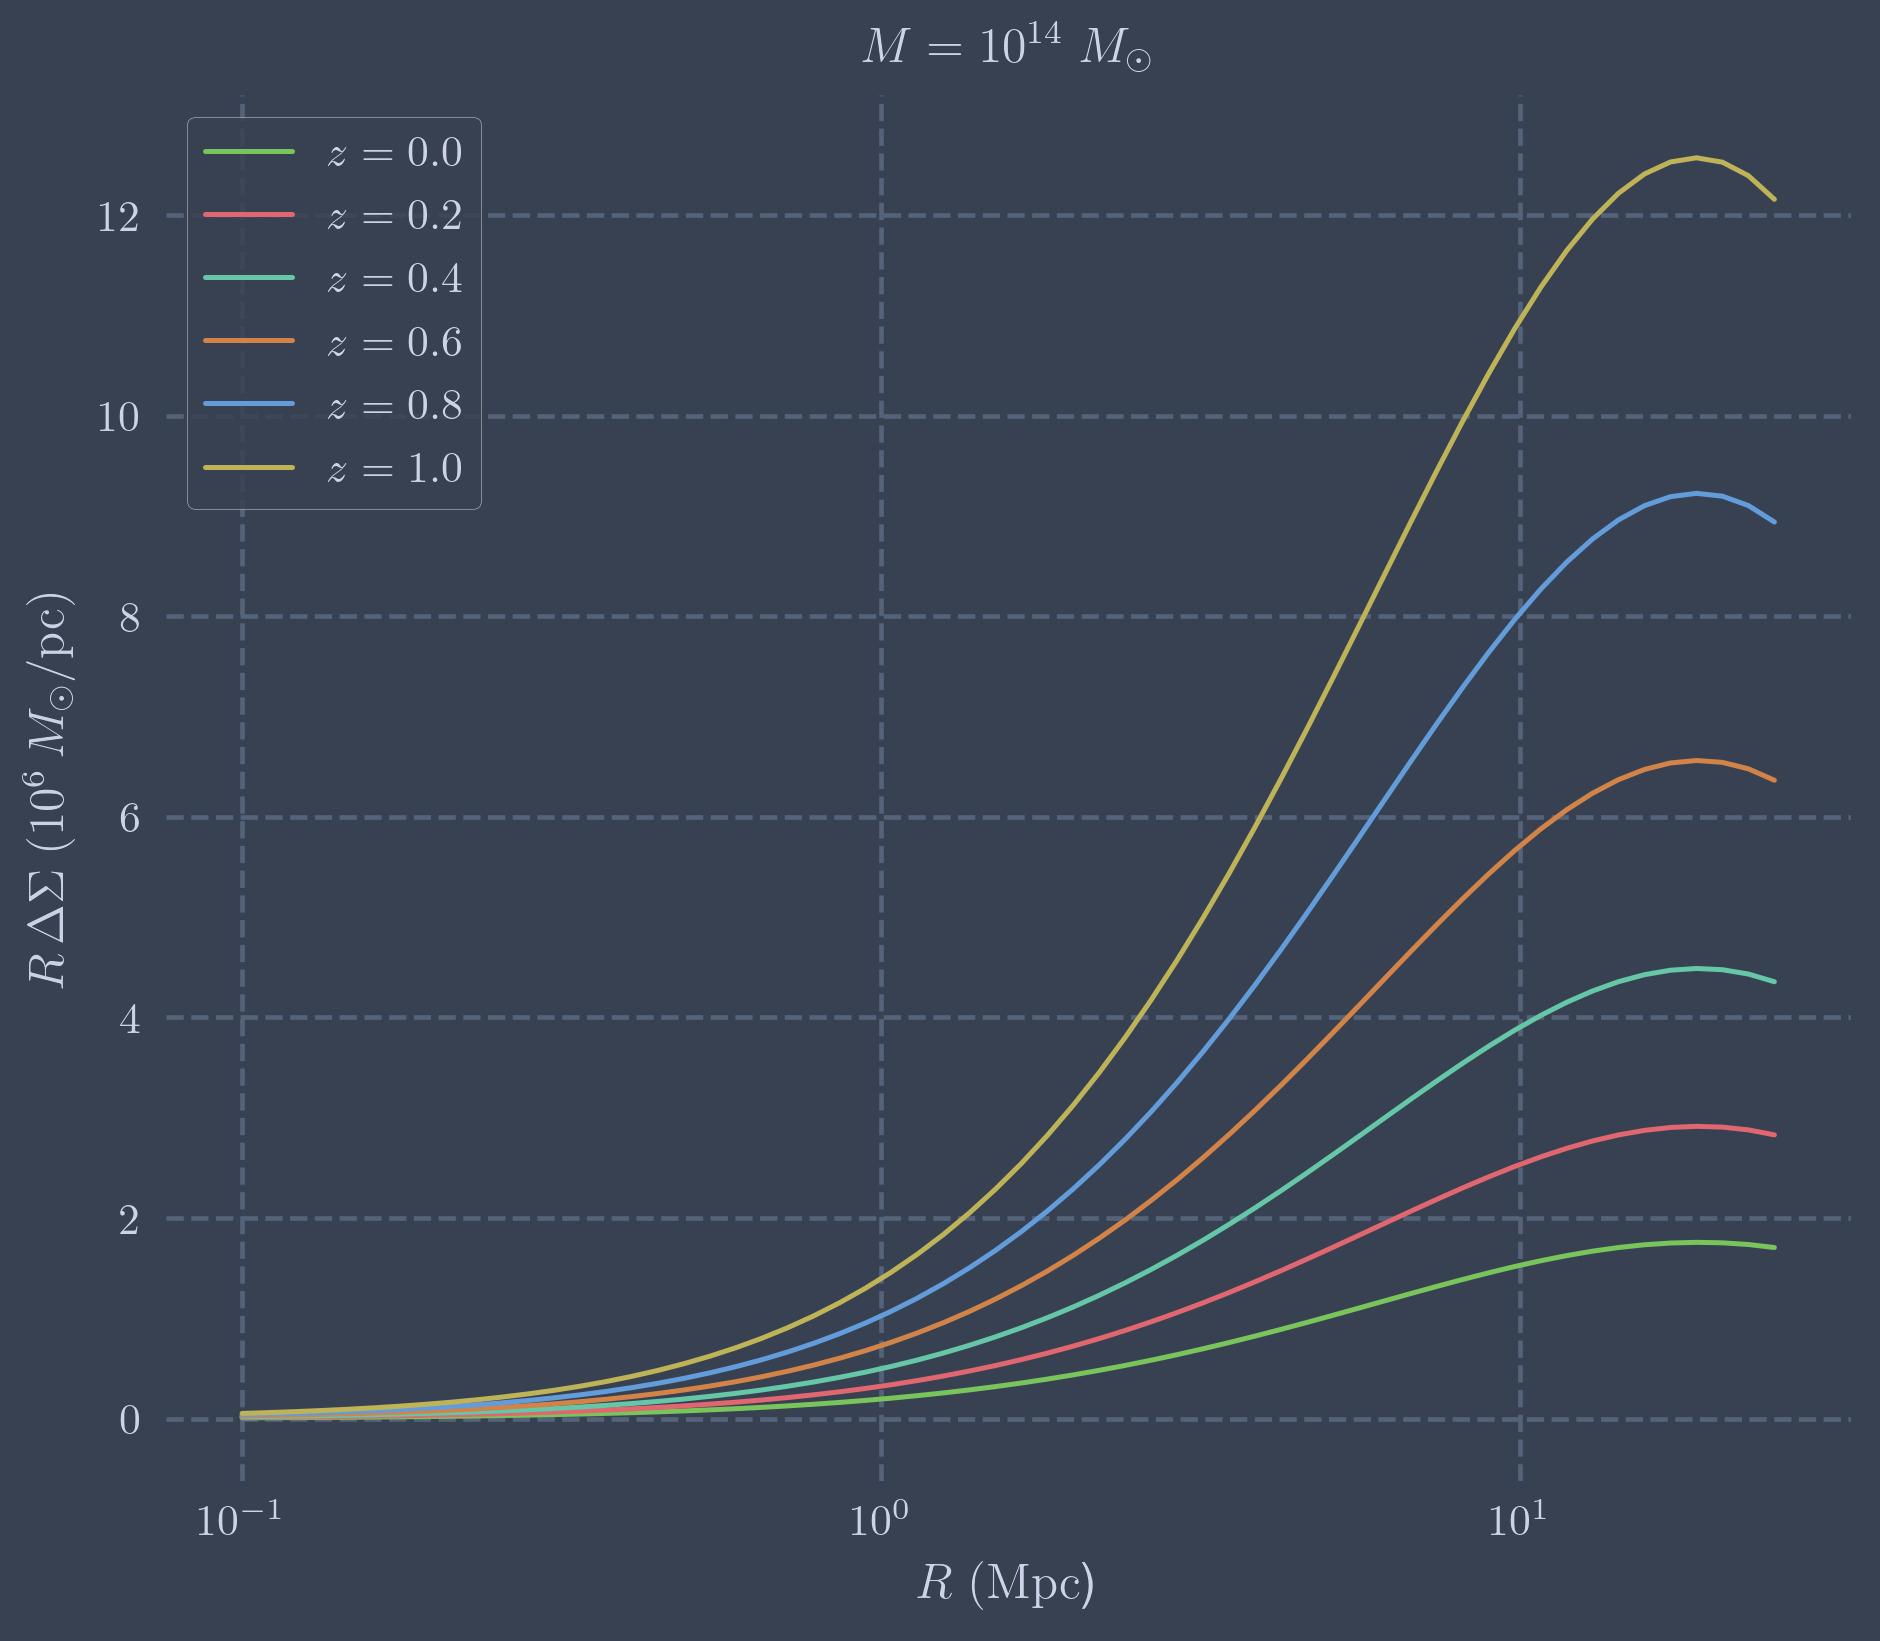

In [32]:
for i in range(6):
    plt.plot(rs, rs*esds_lin[0, i, :], color=colors[i], label=fr'$z={round(zs[i], 2)}$')
plt.xscale('log')
plt.xlabel(r'$R \; (\mathrm{Mpc}$)')
plt.ylabel(r'$R \, \Delta \Sigma \; (10^6 \, M_\odot/\mathrm{pc})$')
plt.legend(loc='best')
plt.title(r'$M = 10^{14} \; M_\odot$')
pass

plt.savefig('2-halo-r-esd-lin_zs.pdf')

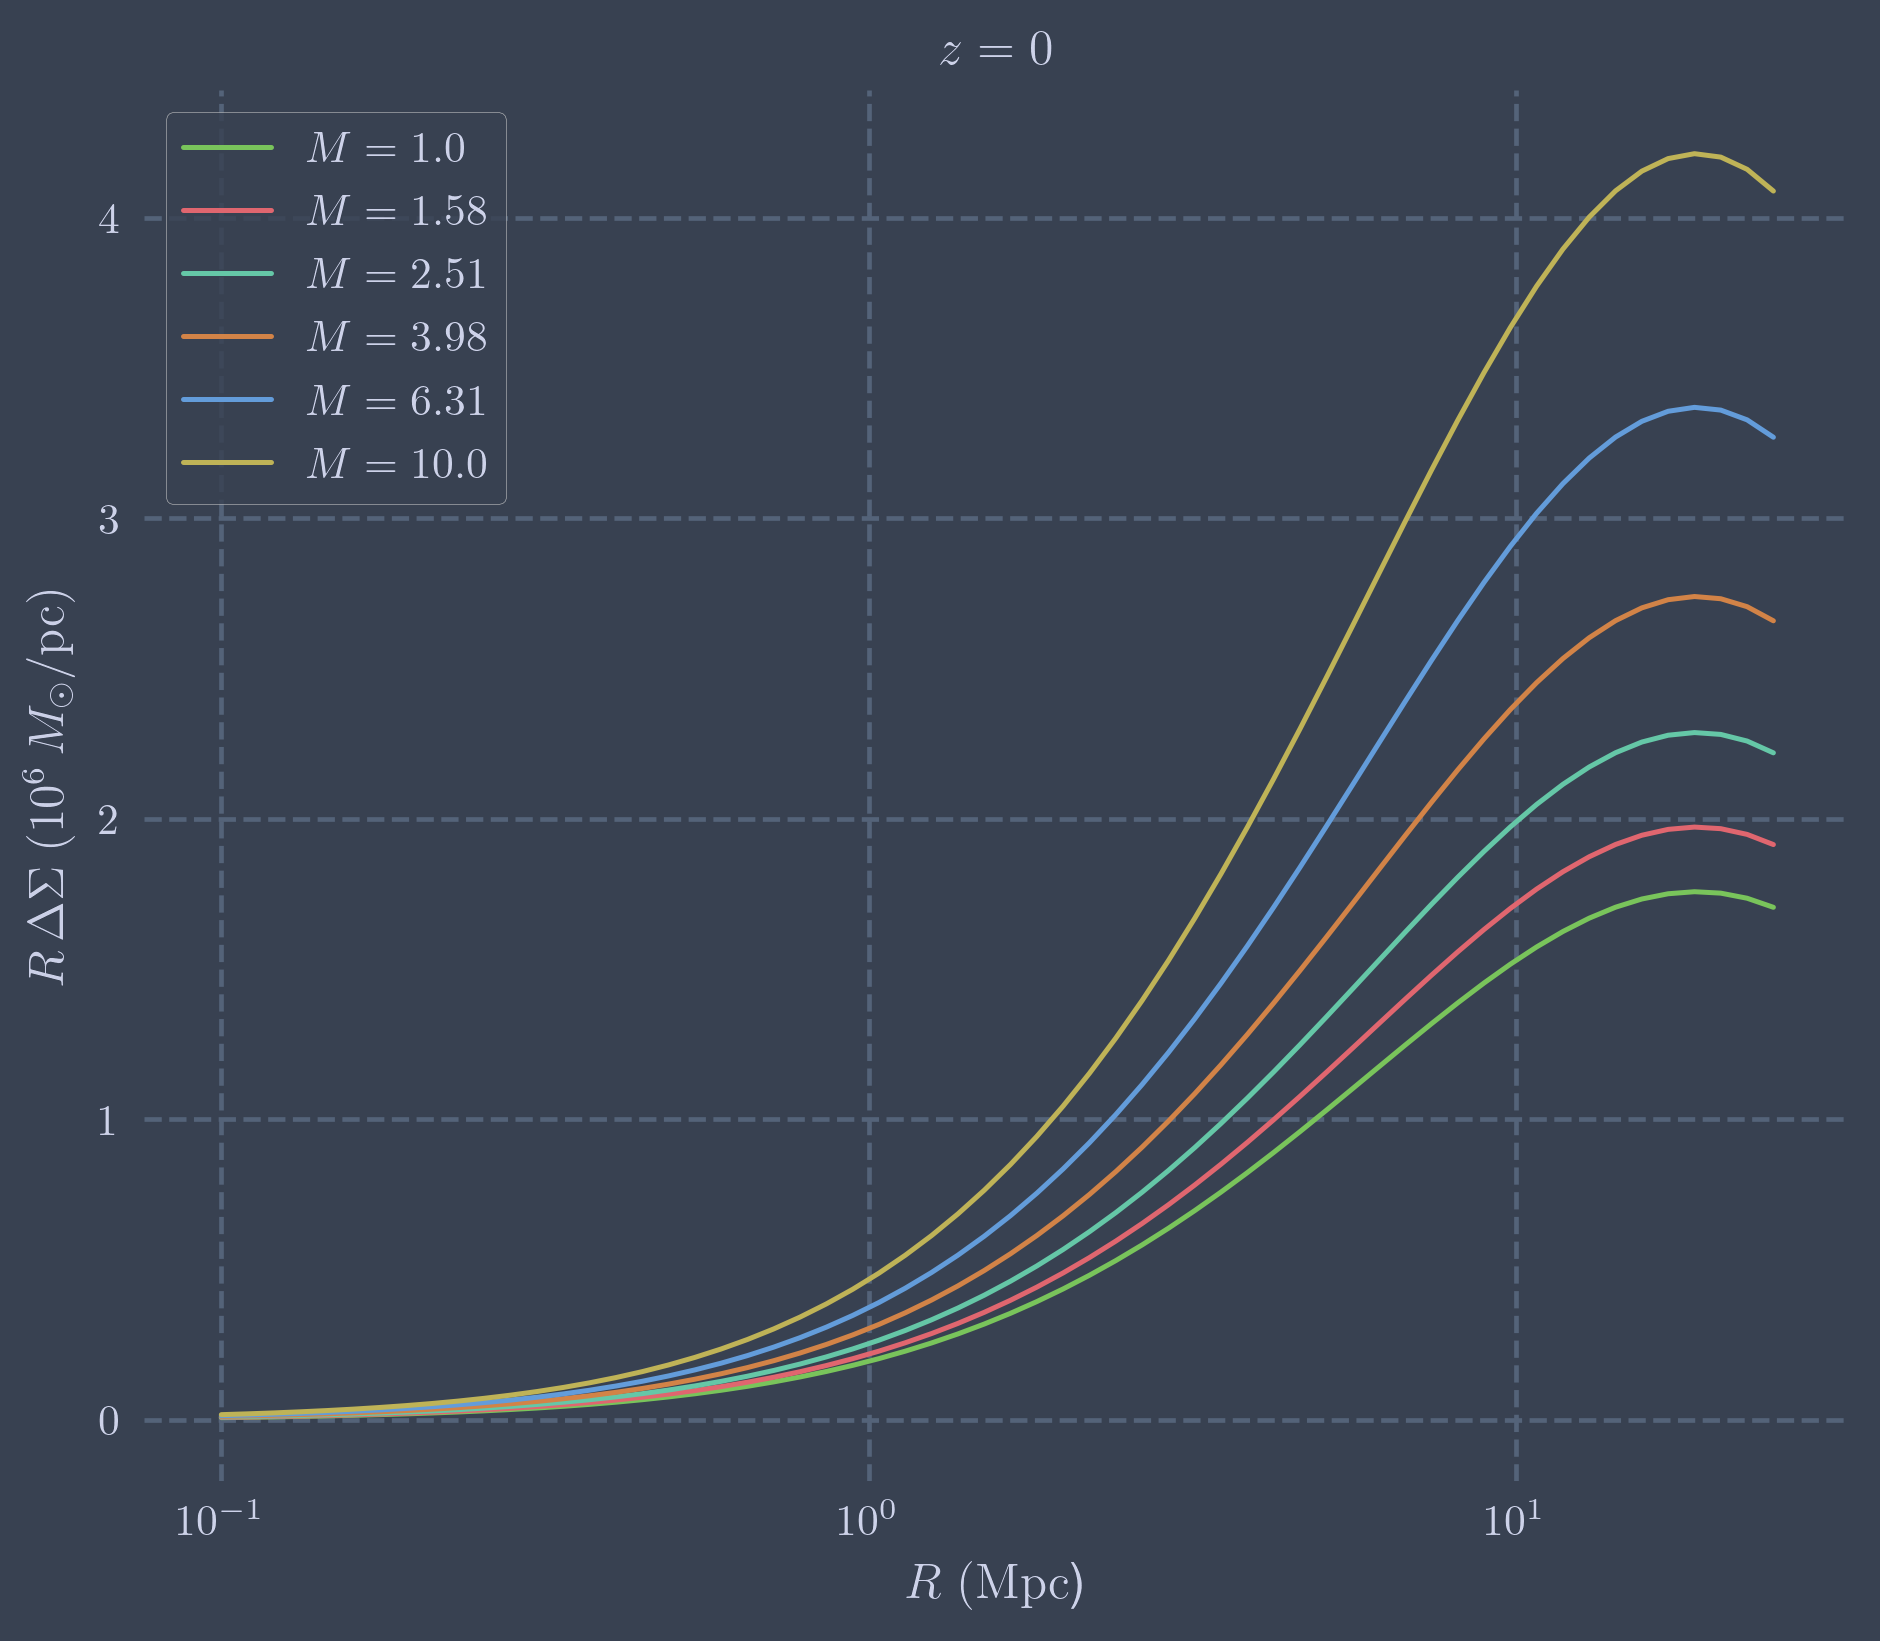

In [33]:
for i in range(6):
    plt.plot(rs, rs*esds_lin[i, 0, :], color=colors[i], label=fr'$M={round(np.exp(mus[i])/1e14, 2)}$')
plt.xscale('log')
plt.xlabel(r'$R \; (\mathrm{Mpc}$)')
plt.ylabel(r'$R \, \Delta \Sigma \; (10^6 \, M_\odot/\mathrm{pc})$')
plt.legend(loc='best')
plt.title(r'$z = 0$')
pass

plt.savefig('2-halo-r-esd-lin_ms.pdf')

In [36]:
two_halo_model_cut_ks = maszcal.twohalo.TwoHaloShearModel(cosmo_params=CosmoParams())
two_halo_model_cut_ks.MAX_K = 10

In [42]:
fine_rs = np.logspace(-1, 1, 80)
esds_cut_ks = two_halo_model_cut_ks.esd(fine_rs, mus, zs)

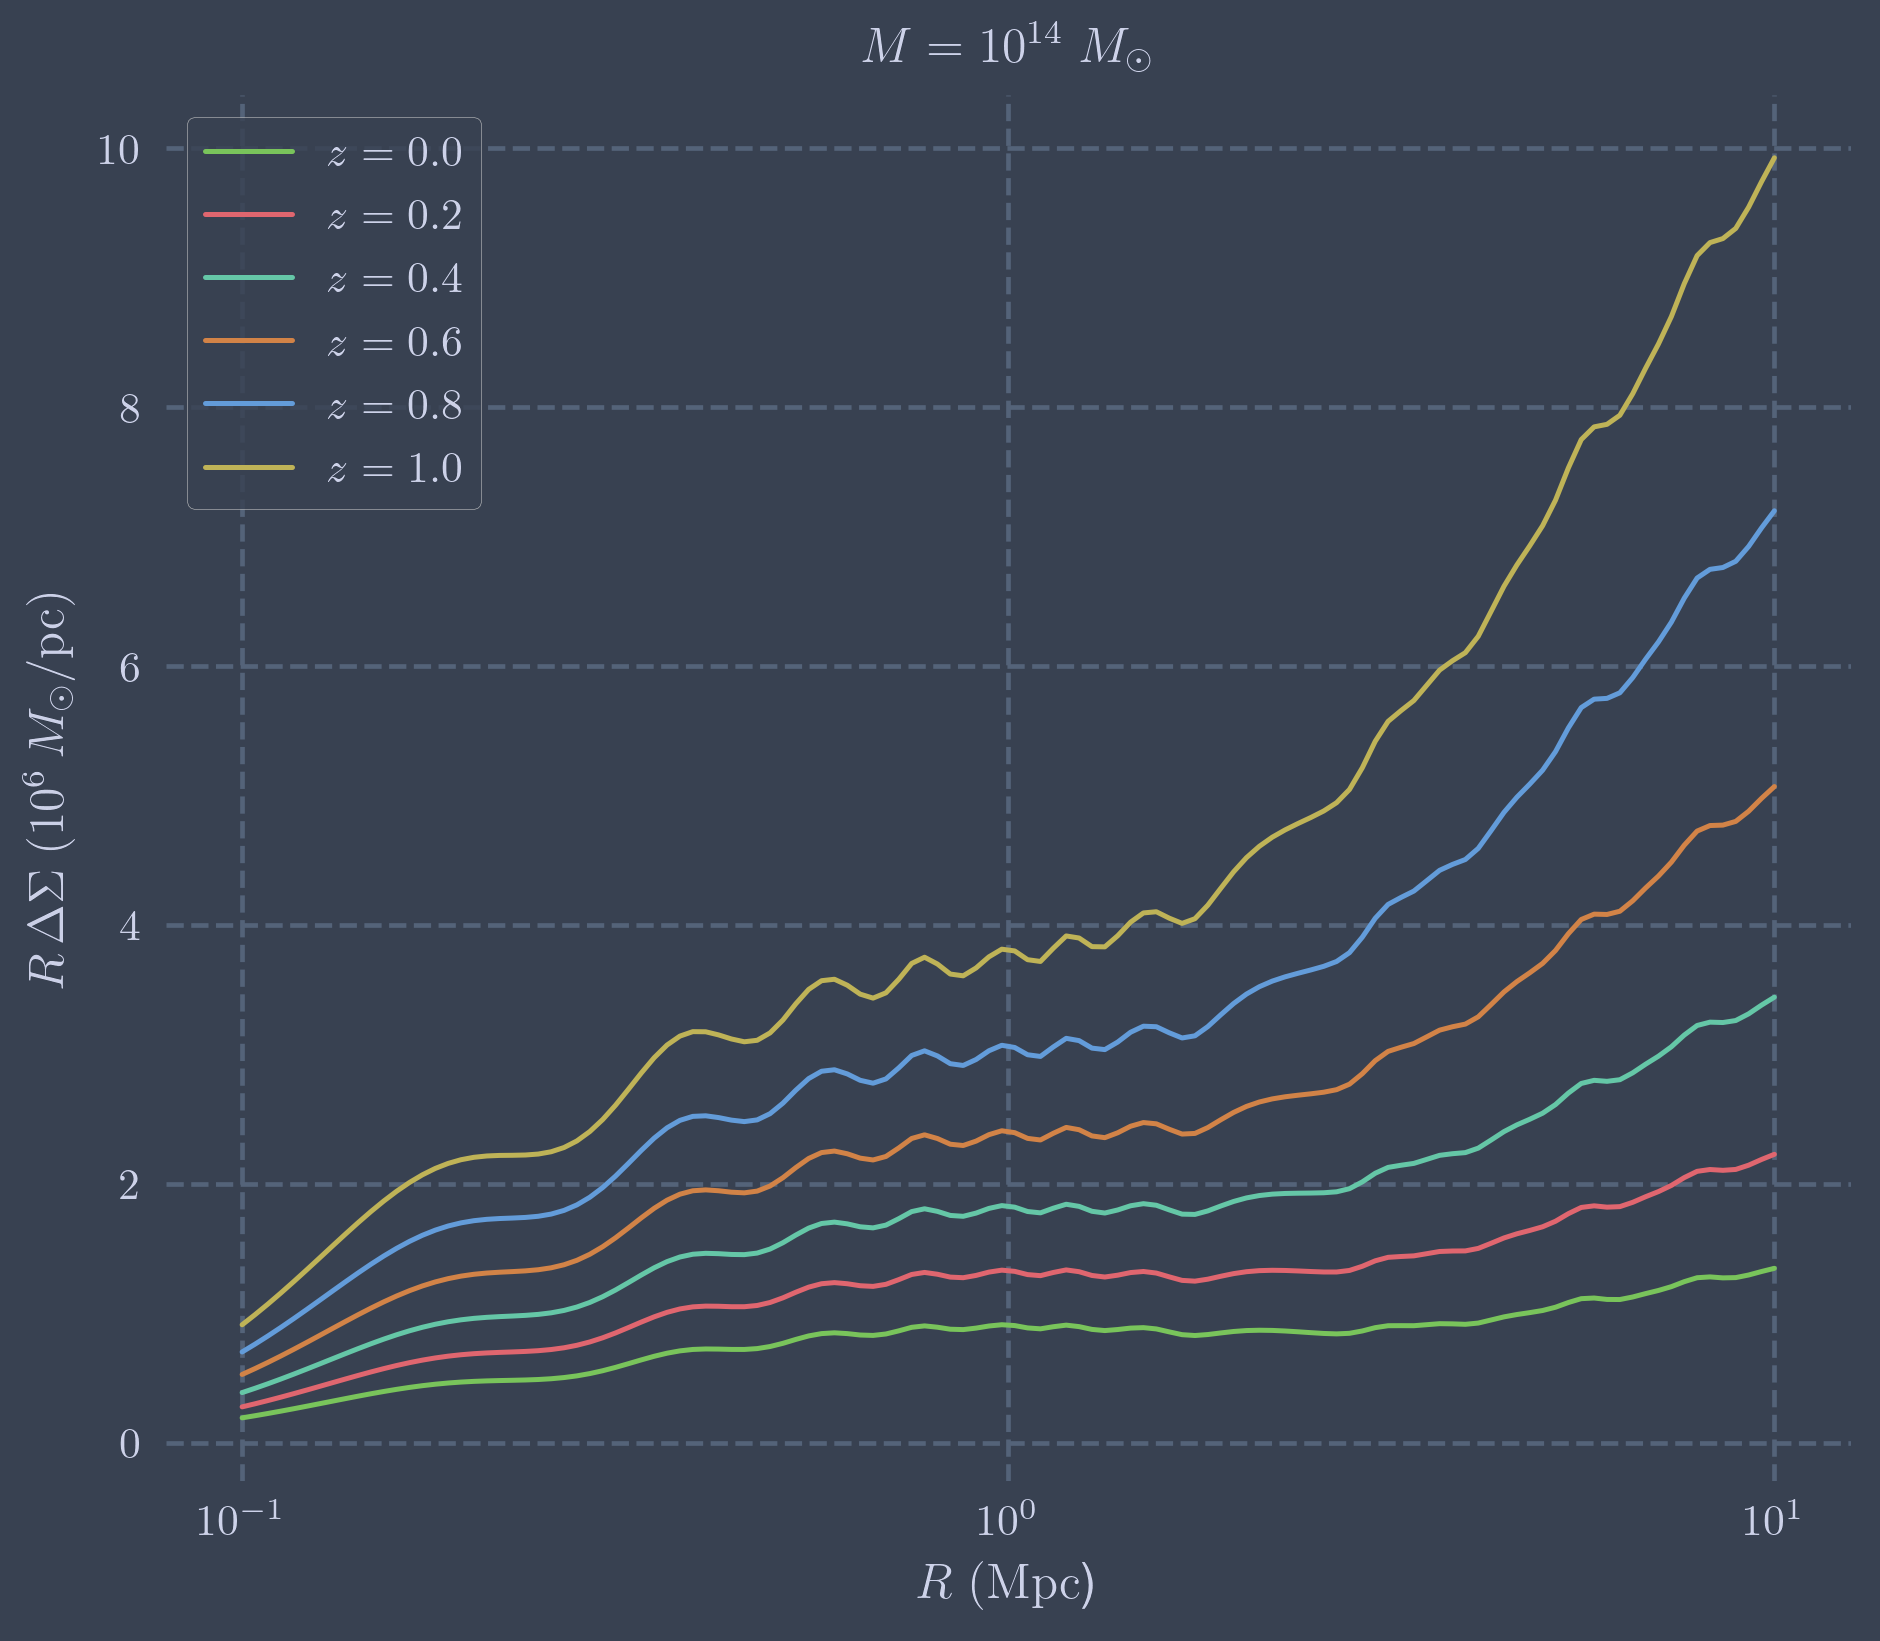

In [43]:
for i in range(6):
    plt.plot(fine_rs, fine_rs*esds_cut_ks[0, i, :], color=colors[i], label=fr'$z={round(zs[i], 2)}$')
plt.xscale('log')
plt.xlabel(r'$R \; (\mathrm{Mpc}$)')
plt.ylabel(r'$R \, \Delta \Sigma \; (10^6 \, M_\odot/\mathrm{pc})$')
plt.legend(loc='best')
plt.title(r'$M = 10^{14} \; M_\odot$')
pass

plt.savefig('2-halo-r-esd-cut-ks_zs.pdf')

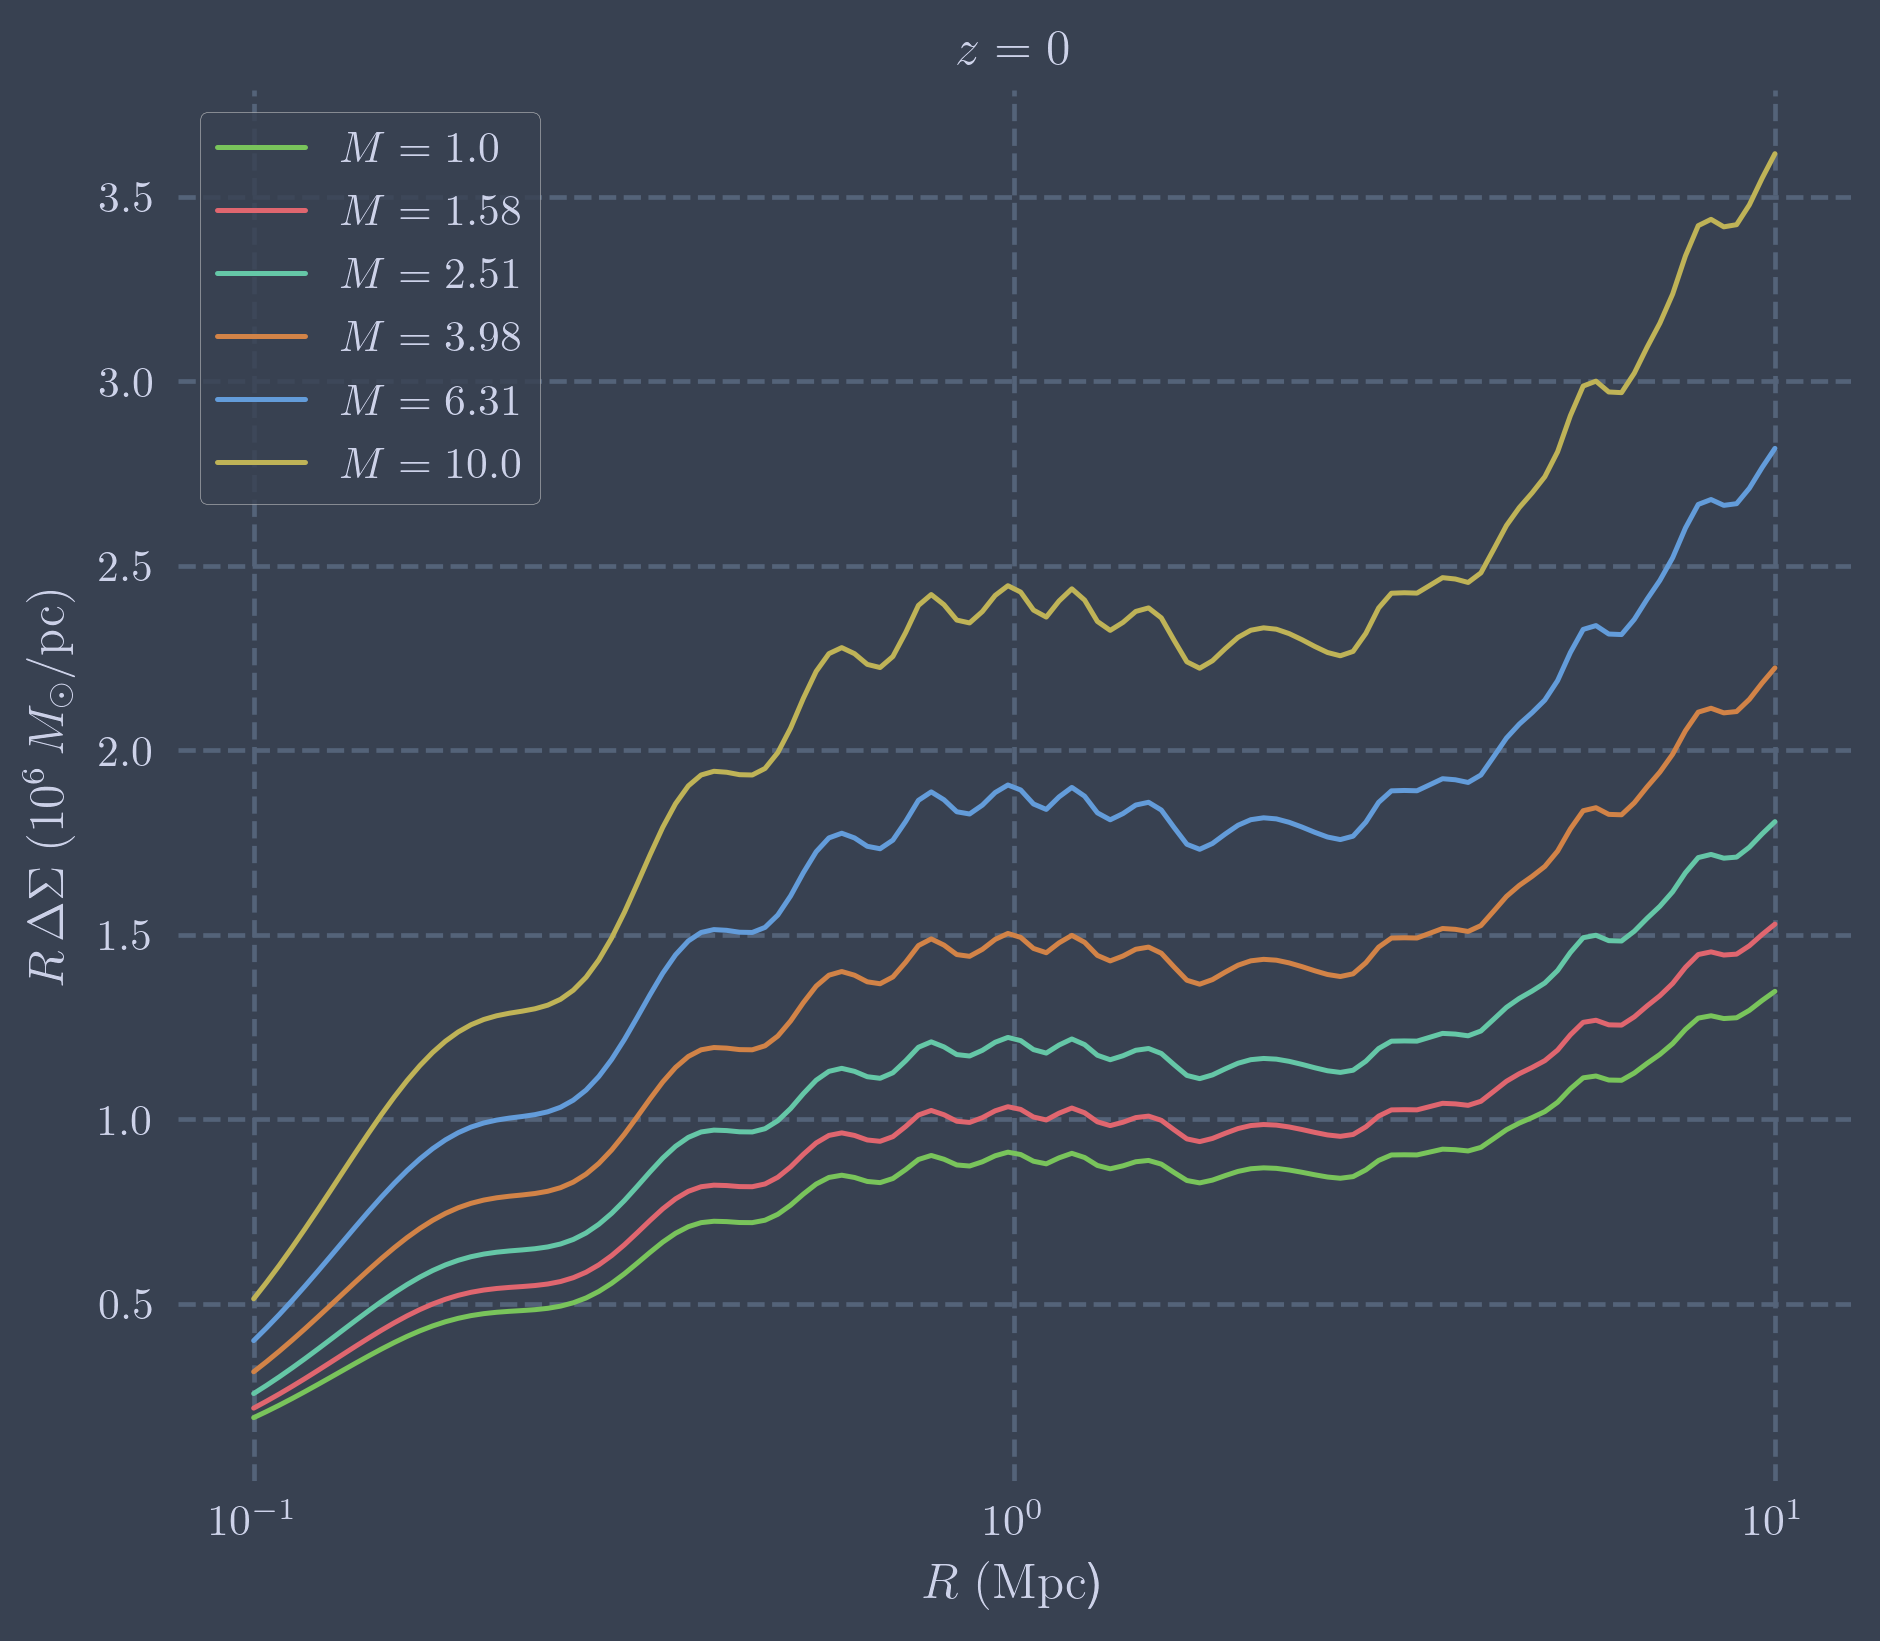

In [44]:
for i in range(6):
    plt.plot(fine_rs, fine_rs*esds_cut_ks[i, 0, :], color=colors[i],
             label=fr'$M={round(np.exp(mus[i])/1e14, 2)}$')
plt.xscale('log')
plt.xlabel(r'$R \; (\mathrm{Mpc}$)')
plt.ylabel(r'$R \, \Delta \Sigma \; (10^6 \, M_\odot/\mathrm{pc})$')
plt.legend(loc='best')
plt.title(r'$z = 0$')
pass

plt.savefig('2-halo-r-esd-cut-ks_ms.pdf')